In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import plotly.express as px
import pandas as pd

pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from get_dataframes import GetDataframes
import hjson

import matplotlib.pyplot as plt
import explo_data_analysis.eda_movies as eda

with open("config.hjson") as fp:
    config = hjson.load(fp)

In [3]:
datas = GetDataframes(config)
link = "actors_movies"
df = datas.get_dataframes(
    link,
)

2023-10-30 12:20:29 INFO     TSV files already exist.
2023-10-30 12:20:29 INFO     Parquet loaded ! Importing actors_movies...
2023-10-30 12:20:30 INFO     Dataframe actors_movies ready to use!


In [7]:
df["person_name"].value_counts()

person_name
Gérard Depardieu        135
John Wayne              108
Catherine Deneuve       102
Michel Piccoli          101
Marcello Mastroianni    100
                       ... 
John Amplas               1
Christine Forrest         1
Elyane Nadeau             1
Sally Erwin               1
Elizabett Conceição       1
Name: count, Length: 83292, dtype: int64

**JME SUIS ARRETÉ LA**


In [8]:
df = df.copy()

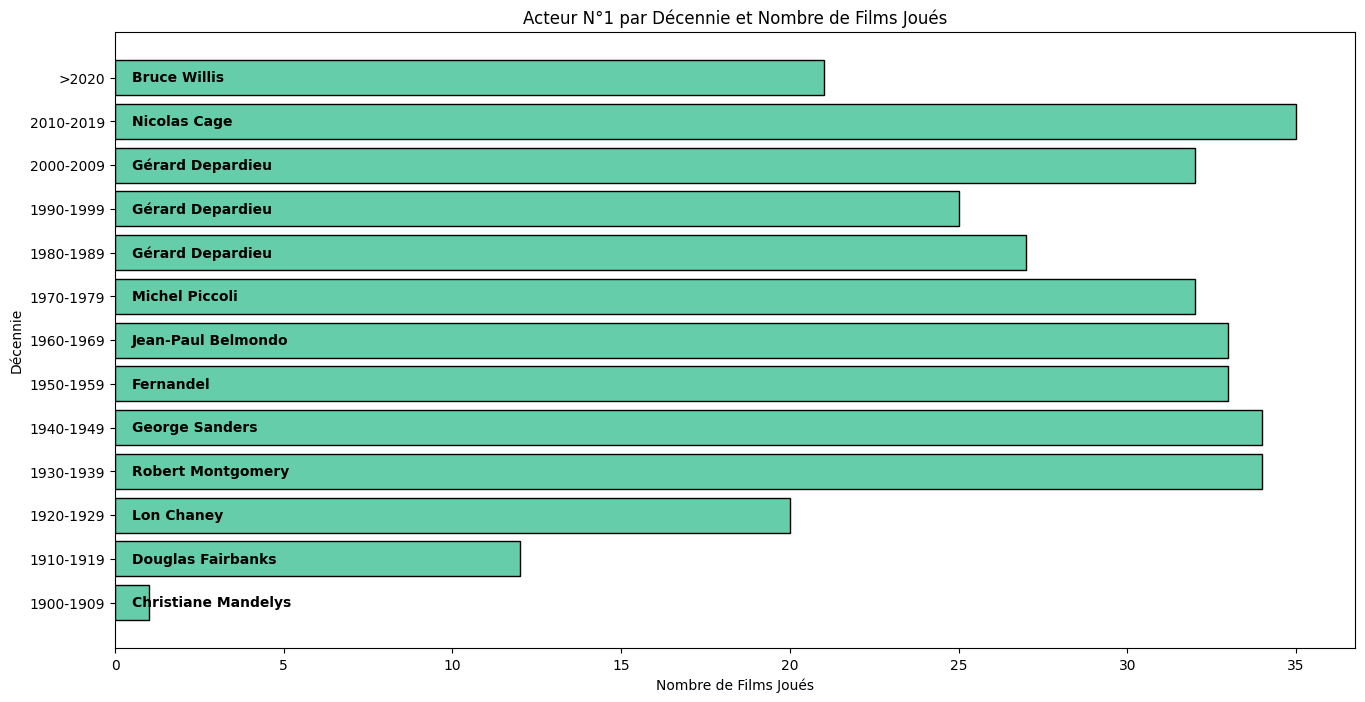

In [51]:
grouped_df = df.groupby(
    ['cuts', 'person_name'],
            observed=True
).size().reset_index(name='total_film_acteurs').sort_values(by="total_film_acteurs")

top_acteurs_decennie = grouped_df.groupby(
    'cuts',
            observed=True
).apply(lambda x: x.nlargest(1, 'total_film_acteurs')).reset_index(drop=True)

decennies = top_acteurs_decennie['cuts']
noms_acteurs = top_acteurs_decennie['person_name']
nombre_films = top_acteurs_decennie['total_film_acteurs']

plt.figure(figsize=(16, 8))
bars = plt.barh(
    decennies,
    nombre_films,
    color='#66cdaa',
    edgecolor="black"
)
for i, (count, name) in enumerate(zip(
    top_acteurs_decennie['total_film_acteurs'],
    top_acteurs_decennie['person_name'])):
    plt.text(0.5, i, name, color='black', va='center', ha='left', fontweight='bold')

plt.title('Acteur N°1 par Décennie et Nombre de Films Joués')
plt.xlabel('Nombre de Films Joués')
plt.ylabel('Décennie')
plt.show()


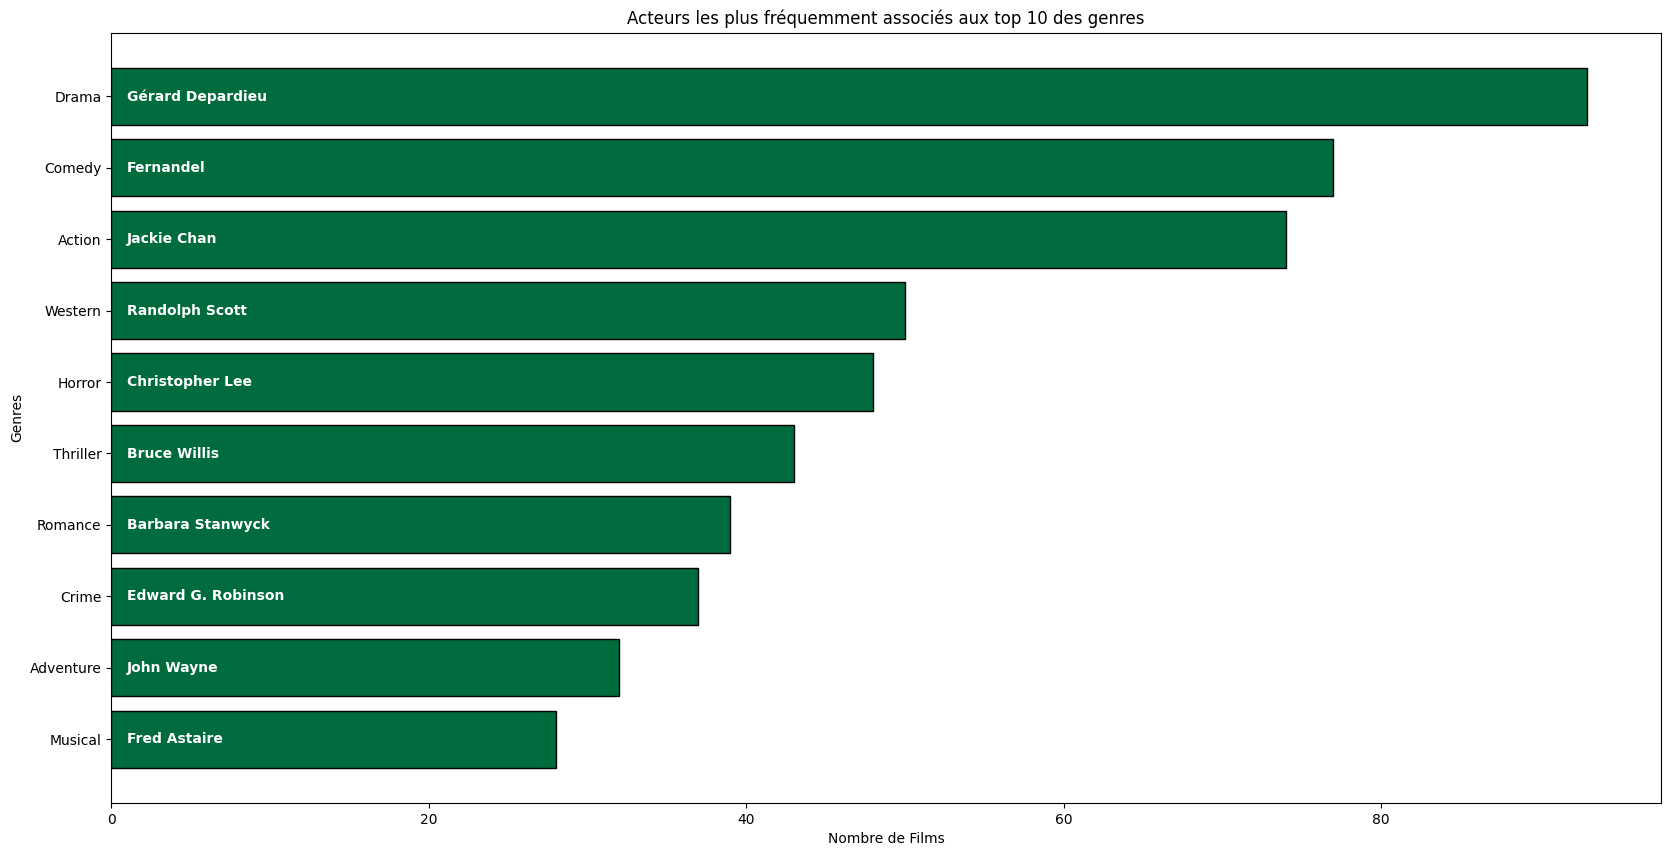

In [21]:
actors_by_genre = df.explode('titre_genres').groupby(['person_name', 'titre_genres']).size().reset_index(name='count')
top_actors_by_genre = actors_by_genre.sort_values('count', ascending=False).drop_duplicates('titre_genres')[:10][::-1]

plt.figure(figsize=(20, 10))
plt.barh(
    top_actors_by_genre['titre_genres'],
    top_actors_by_genre['count'],
    color='#006b3c',
    edgecolor = "black",
)
plt.xlabel('Nombre de Films')
plt.ylabel('Genres')
plt.title('Acteurs les plus fréquemment associés aux top 10 des genres')

for i, (count, name) in enumerate(zip(
    top_actors_by_genre['count'],
    top_actors_by_genre['person_name'])):
    plt.text(1, i, name, color='white', va='center', ha='left', fontweight='bold')


plt.show()


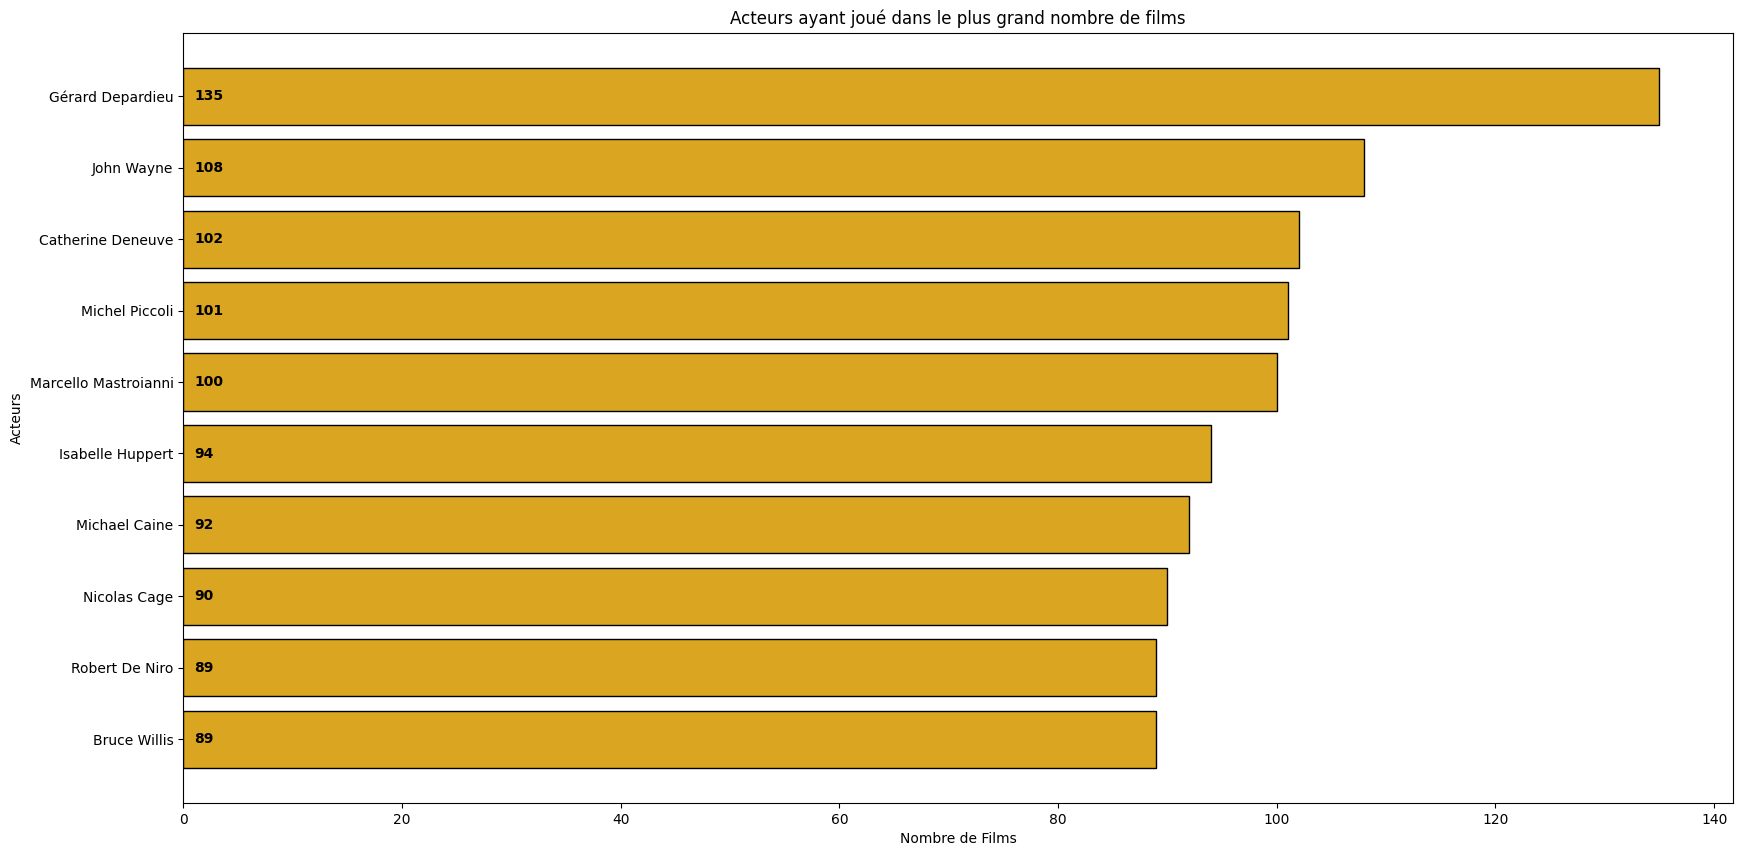

In [23]:
actors_film_count = df.groupby('person_name').size().reset_index(name='film_count')

top_actors_film_count = actors_film_count.sort_values('film_count', ascending=False).head(10)[::-1]

plt.figure(figsize=(20, 10))
plt.barh(
    top_actors_film_count['person_name'],
    top_actors_film_count['film_count'],
    color='#daa520',
    edgecolor="black",
)
for i, (count, name) in enumerate(zip(
    top_actors_film_count['person_name'],
    top_actors_film_count['film_count'])):
    plt.text(1, i, name, color='black', va='center', ha='left', fontweight='bold')

plt.xlabel('Nombre de Films')
plt.ylabel('Acteurs')
plt.title('Acteurs ayant joué dans le plus grand nombre de films')
plt.show()


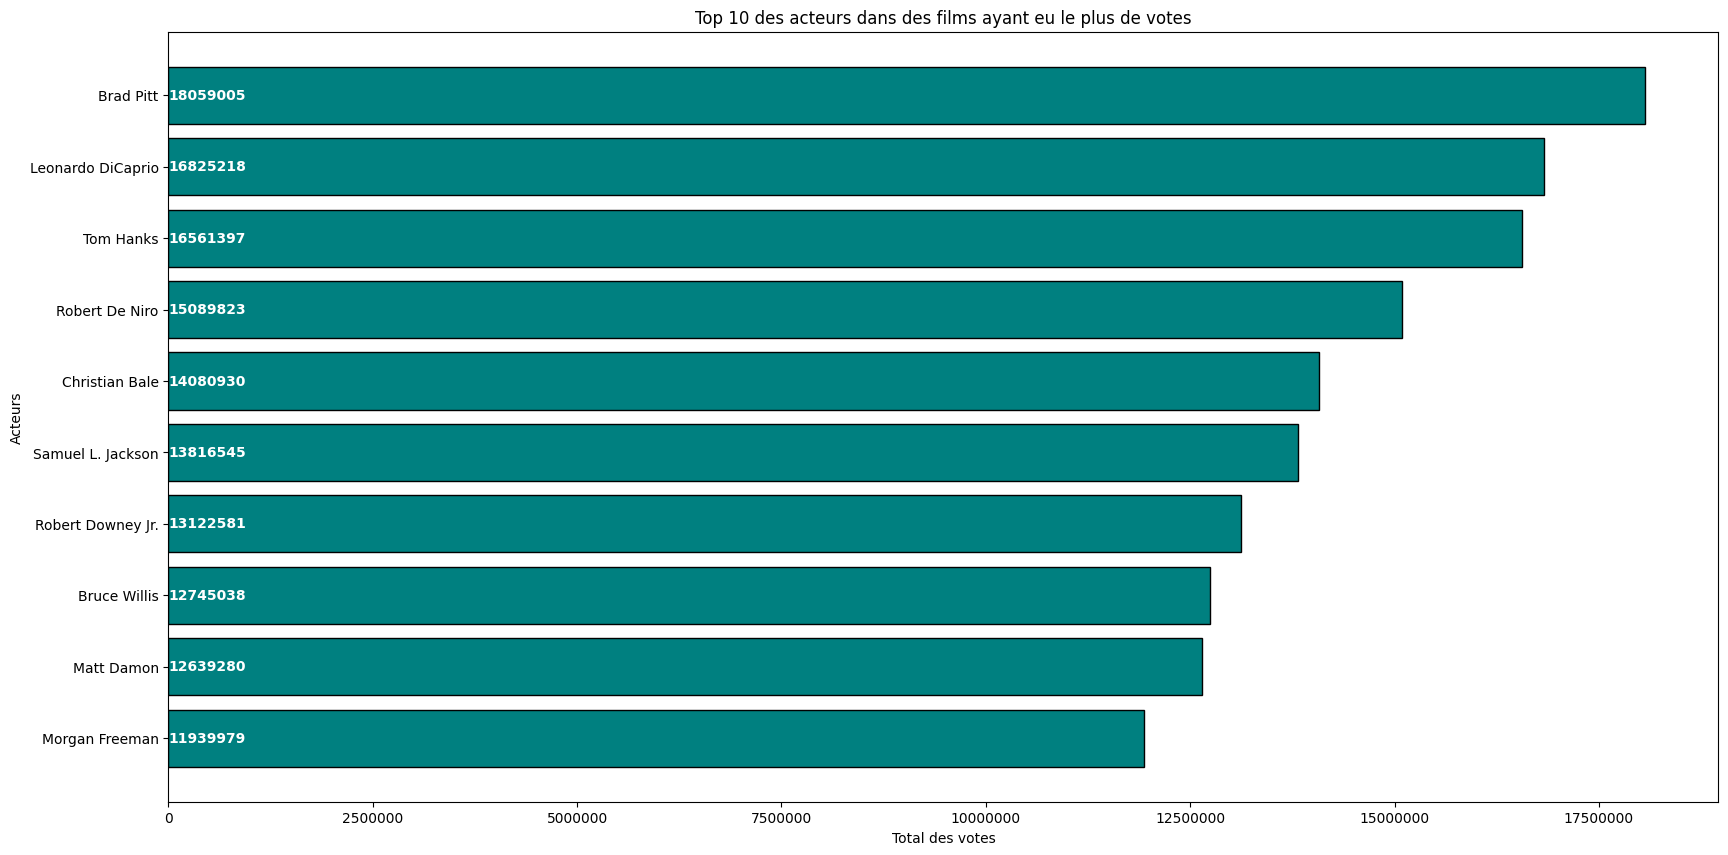

In [40]:
actors_by_votes = df.groupby('person_name')['rating_votes'].sum().reset_index()

top_actors_by_votes = actors_by_votes.sort_values('rating_votes', ascending=False).head(10)[::-1]

plt.figure(figsize=(20, 10))
plt.barh(
    top_actors_by_votes['person_name'],
    top_actors_by_votes['rating_votes'],
    color='#008080',
    edgecolor = "black"
)
for i, (count, name) in enumerate(zip(
    top_actors_by_votes['person_name'],
    top_actors_by_votes['rating_votes'])):
    plt.text(1, i, name, color='white', va='center', ha='left', fontweight='bold')

plt.xlabel('Total des votes')
plt.ylabel('Acteurs')
plt.title('Top 10 des acteurs dans des films ayant eu le plus de votes')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


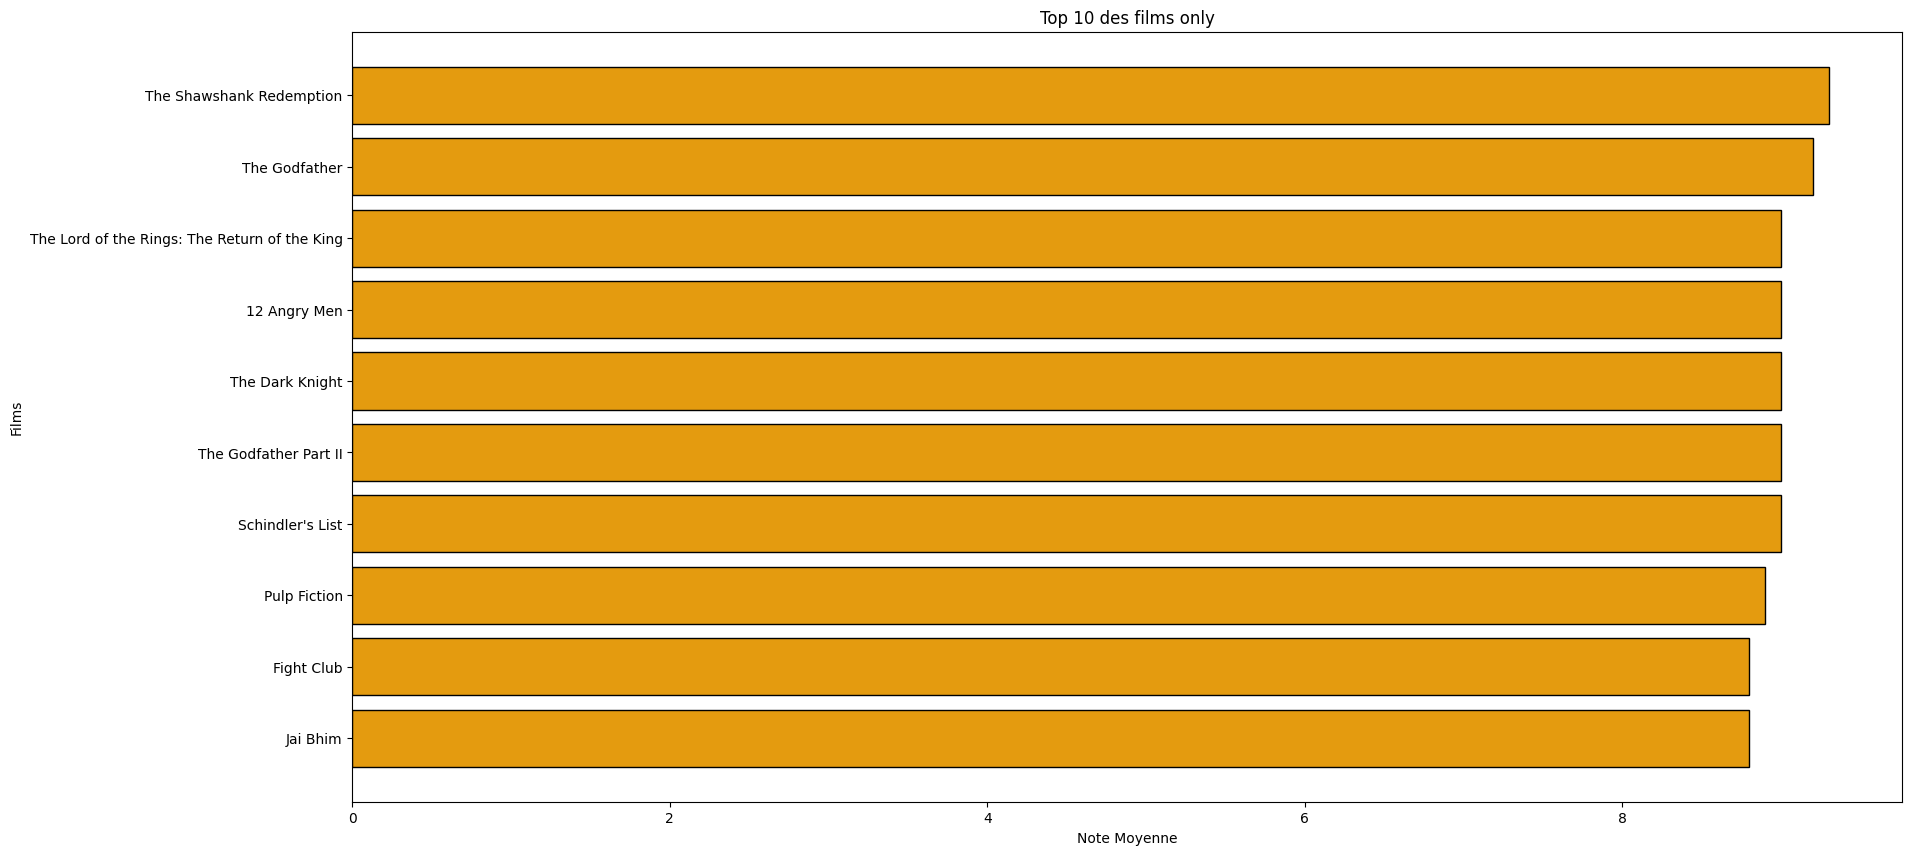

In [13]:
# Je dégage pour les films d'animation les concerts et les docs.
genres_ = ['Animation', 'Music', 'Musical', 'Documentary']
df_filtre = df[df['titre_genres'].apply(lambda x: all(g not in x for g in genres_))]
# Je veux uniquement les films ayant eu le plus de vote, je filtre par quantile 0.75 sup only.
df_filtre = df_filtre[df_filtre['rating_votes'] > df_filtre['rating_votes'].quantile(0.75)]

# Groupe les films par la moyenne ratings, ne prend que le top 10
grouped_films = (
    df_filtre.groupby('titre_str')['rating_avg']
    .mean()
    .reset_index()
    .sort_values("rating_avg", ascending=False)
    .head(10)[::-1]
)

plt.figure(figsize=(20, 10))
plt.barh(
    grouped_films['titre_str'],
    grouped_films['rating_avg'],
    color='#e49b0f',
    edgecolor = "black"
)
plt.xlabel('Note Moyenne')
plt.ylabel('Films')
plt.title('Top 10 des films only')
plt.show()


In [14]:
# Créer un dictionnaire contenant tout les noms des films avec leurs id
titre_dict = df[['titre_id', 'titre_str']].drop_duplicates().set_index('titre_id').to_dict()['titre_str']
# for k, v in titre_dict.items():
#     print(k, v)

In [15]:
df1 = df.copy()

In [16]:
import ast

# Fonction pour remplacer les identifiants dans une liste par les noms de titre
def replace_ids_with_titles(id_list):
    if isinstance(id_list, str):
        id_list = ast.literal_eval(id_list)
    return [titre_dict.get(titre_id, titre_id) for titre_id in id_list]

# Omn créer une nouvelle colonne pour le fun !
df1['person_films'] = df1['person_film'].apply(replace_ids_with_titles)



In [19]:
gerard = df1[df1["person_name"].str.contains("Morgan")]
# gerard = gerard.copy()
gerard.head()

# on a une problemen, si les films ne sont pas dans la liste initial tconst, alors nous n'avons pas de modification, que faire ?
# remplacer par unknow ? supprimer les tt dans la liste et ne conserver que les films convertie ?

def if_tt_remove(id_list):
    return [t for t in id_list if not t.startswith("tt")]

In [20]:
gerard.loc[:, 'person_films'] = gerard['person_films'].apply(if_tt_remove)
gerard

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,...,region,cuts,person_id,person_name,person_birthdate,person_job,person_role,person_film,person_index,person_films
291,tt0002199,From the Manger to the Cross,1912,60,"[Biography, Drama]",5.80,621,en,From the Manger to the Cross,1.16,...,FR,1910-1919,nm0605017,Samuel Morgan,0,actor,[Pilate],[tt0002199],7,[From the Manger to the Cross]
952,tt0023374,Rasputin and the Empress,1932,121,"[Biography, Drama, History]",6.50,1146,en,Rasputin and the Empress,3.34,...,FR,1930-1939,nm0604960,Ralph Morgan,1883,actor,[The Czar - Nicholai Alexander],"[tt0024465, tt0023374, tt0026667, tt0023523]",4,"[The Power and the Glory, Rasputin and the Emp..."
1006,tt0029516,Saratoga,1937,92,"[Comedy, Drama, Romance]",6.50,1856,en,Saratoga,3.18,...,FR,1930-1939,nm0604656,Frank Morgan,1890,actor,[Jesse Kiffmeyer],"[tt0035460, tt0028416, tt0032138, tt0033045]",4,"[Tortilla Flat, Trouble for Two, The Wizard of..."
1644,tt0028959,Heart of Paris,1937,86,"[Comedy, Drama]",6.60,154,fr,Gribouille,1.96,...,FR,1930-1939,nm0006807,Michèle Morgan,1920,actress,[Natalie Roguin],"[tt0030643, tt0038409, tt0039004, tt0040338]",2,"[Port of Shadows, The Chase, Pastoral Symphony..."
1849,tt0033209,The Heart of a Nation,1943,113,"[Drama, War]",6.20,135,fr,Untel père et fils,0.93,...,FR,1940-1949,nm0006807,Michèle Morgan,1920,actress,[Marie Froment-Léonard],"[tt0030643, tt0038409, tt0039004, tt0040338]",2,"[Port of Shadows, The Chase, Pastoral Symphony..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207754,tt13785940,Virus Shark,2021,74,"[Horror, Sci-Fi]",1.70,393,en,Virus Shark,3.36,...,FR,>2020,nm5840110,Jamie Morgan,0,actress,[Kristi Parks],"[tt15241706, tt14873410, tt8387464, tt12057580]",1,[]
207919,tt3196692,House of VHS,2016,83,"[Fantasy, Horror, Mystery]",2.50,167,en,House of VHS,1.31,...,FR,2010-2019,nm5633489,Morgan Lamorté,0,actor,[The French Guy],"[tt2852678, tt9072388, tt6912568, tt3196692]",3,[House of VHS]
207999,tt5329376,Beware the Slenderman,2016,114,"[Biography, Crime, Documentary]",6.20,7617,en,Beware the Slenderman,8.98,...,FR,2010-2019,nm7845237,Morgan Geyser,0,self,[Self - Stabbing Suspect],"[tt0124932, tt5329376]",1,[Beware the Slenderman]
210114,tt5278596,Weiner,2016,96,[Documentary],7.60,10444,en,Weiner,5.65,...,FR,2010-2019,nm8450577,Barbara Morgan,0,self,[Self - Communications Director],[tt5278596],4,[Weiner]
